In [ ]:
from urllib.parse import urlparse, parse_qs
from langgraph.graph import MessagesState, StateGraph
from dotenv import load_dotenv
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START
from langgraph.prebuilt import ToolNode, tools_condition
from youtube_transcript_api import YouTubeTranscriptApi

In [2]:
load_dotenv()

True

In [ ]:
llm = ChatOpenAI(model="gpt-4o", streaming=True)

In [ ]:
class AgentState(MessagesState):
    pass

graph_builder = StateGraph(AgentState)

In [5]:
@tool
def get_youtube_transcript(video_url: str, max_transcript_chars: int = 10000) -> dict:
    """
    주어진 유튜브 URL에서 영상의 스크립트(자막)를 추출합니다.
    성공 시 스크립트 텍스트를, 실패 시 에러 메시지를 반환합니다.
    """
    print("🚀 [Tool] get_youtube_transcript 호출됨")
    try:
        # URL에서 비디오 ID 추출
        parsed_url = urlparse(video_url)
        hostname = parsed_url.hostname or ""
        video_id = None
        if "youtu.be" in hostname:
            video_id = parsed_url.path[1:]
        elif "youtube.com" in hostname:
            qs = parse_qs(parsed_url.query)
            video_id = qs.get("v", [None])[0]

        if not video_id:
            return {"error": "유효한 유튜브 URL에서 Video ID를 추출할 수 없습니다."}

        # 자막 추출
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=['ko', 'en'])
        full_transcript = " ".join([item['text'] for item in transcript_list])

        # 자막 길이 제한
        if len(full_transcript) > max_transcript_chars:
            print(f"⚠️ 자막 크기 초과. 일부만 사용 (최대 {max_transcript_chars}자)")
            full_transcript = full_transcript[:max_transcript_chars]
        
        # 자막 내용 유효성 검사
        if len(full_transcript) < 100:
             return {"error": "자막 내용이 너무 짧아 요약할 수 없습니다."}

        print("✅ 1. 자막 추출 성공")
        return {"transcript": full_transcript}

    except Exception as e:
        error_message = f"자막을 가져오는 데 실패했습니다: {e}"
        print(f"🚨 [Tool] 에러: {error_message}")
        return {"error": error_message}

In [6]:
summarize_prompt = ("너는 유튜브 영상 URL을 입력받아, 해당 영상의 자막을 추출하고 분석하는 AI 에이전트야.\n\n"
                    "**업무 흐름:**\n\n"
                    "1. **자막 추출:** 먼저 'get_youtube_transcript' 도구를 사용해 영상의 자막(스크립트)을 가져와.\n"
                    "   - **성공 시:** 추출된 스크립트를 다음 단계로 넘겨.\n"
                    "   - **실패 시:** 요약을 시도하지 말고, 발생한 에러 메시지를 사용자에게 그대로 전달해.\n\n"
                    "2. **내용 분석 및 요약:** 자막 추출에 성공하면, 스크립트 내용을 'summarize_transcript' 도구를 사용하여 분석하고 요약해. 최종 결과물은 반드시 아래의 '필수 JSON 출력 형식'을 완벽하게 따라야 해.\n\n"
                    "--- \n\n"
                    "**필수 JSON 출력 형식:**\n\n"
                    "스크립트를 분석하여 다음 규칙에 따라 JSON 객체를 생성해야 해.\n\n"
                    "- **summary**: 영상 전체 내용을 압축한 핵심 요약\n"
                    "- **intensity**: 영상에서 언급된 운동 강도 (예: 하, 중, 상, 초급자용 등)\n"
                    "- **routine**: 영상에 나오는 각 스트레칭 동작의 정보를 담는 배열. 각 동작은 다음 두 키를 가져야 해.\n"
                    "  - **movement_name**: 스트레칭 동작의 이름\n"
                    "  - **target_body_part**: **스크립트 내용에만 근거하여** 해당 동작이 목표로 하는 신체 부위\n\n"
                    "**중요 규칙:**\n"
                    "- 최종 응답은 **JSON 객체**만 포함해야 해. 어떤 설명이나 추가 텍스트도 넣지 마.\n"
                    "- JSON 내부의 모든 텍스트는 한국어로 작성해야 해.\n\n"
                    "**JSON 구조 예시:**\n"
                    "```json\n"
                    "{\n"
                    '  "summary": "영상 전체 내용을 압축한 핵심 요약",\n'
                    '  "intensity": "영상에서 언급된 운동 강도 (예: 하, 중, 상, 초급자용 등)",\n'
                    '  "routine": [\n'
                    '    {\n'
                    '      "movement_name": "첫 번째 스트레칭 동작 이름",\n'
                    '      "target_body_part": "해당 동작의 타겟 신체 부위"\n'
                    '    },\n'
                    '    {\n'
                    '      "movement_name": "두 번째 스트레칭 동작 이름",\n'
                    '      "target_body_part": "해당 동작의 타겟 신체 부위"\n'
                    '    }\n'
                    '  ]\n'
                    '}\n'
                    "```")

In [7]:
@tool
def summarize_transcript(transcript: str) -> str:
    """
    주어진 스크립트(자막) 텍스트를 바탕으로 영상 내용을 요약합니다.
    """
    print("🚀 [Tool] summarize_transcript 호출됨")
    prompt = [
        SystemMessage(
            content=summarize_prompt
        ),
        HumanMessage(content=f"[분석할 스크립트]\n---\n{transcript}\n---\n\n이 영상의 내용을 핵심만 요약해주세요.")
    ]
    try:
        response = llm.invoke(prompt)
        summary = response.content
        print("✅ 2. 요약 생성 성공")
        return summary
    except Exception as e:
        error_message = f"요약 생성 중 오류가 발생했습니다: {e}"
        print(f"🚨 [Tool] 에러: {error_message}")
        return error_message

In [8]:
tool_list = [get_youtube_transcript, summarize_transcript]
tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [9]:
def agent(state: AgentState) -> AgentState:
    """
    에이전트의 핵심 로직입니다. 현재 상태를 받아 LLM을 호출하고,
    그 결과를 상태에 추가하여 반환합니다.
    """
    print("🤖 [Agent] 호출됨")

    system_message = SystemMessage(
        content=(
            "너는 유튜브 영상 URL을 입력받아, 해당 영상의 자막을 추출하고 요약하는 AI 에이전트야. "
            "먼저 'get_youtube_transcript' 도구를 사용해 자막을 가져와. "
            "자막 추출에 성공하면, 그 결과를 'summarize_transcript' 도구에 넘겨 최종 요약을 생성해. "
            "만약 자막 추출 과정에서 에러가 발생하면, 요약을 시도하지 말고 사용자에게 에러 메시지를 그대로 전달해."
        )
    )

    messages = [system_message] + state["messages"]
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

In [10]:
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)

In [11]:
graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges("agent", tools_condition)
graph_builder.add_edge("tools", "agent")

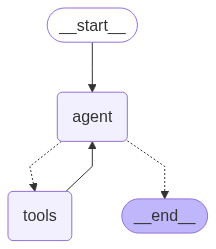

In [12]:
graph = graph_builder.compile()
graph

In [13]:
def run_agent(url: str):
    """에이전트를 실행하고 최종 결과를 스트리밍으로 출력하는 함수"""
    inputs = {"messages": [HumanMessage(content=url)]}
    for chunk in graph.stream(inputs, stream_mode="values"):
        last_message = chunk["messages"][-1]
        if isinstance(last_message, AIMessage) and not last_message.tool_calls:
            print("\n✅ 최종 요약:\n")
            print(last_message.content)

In [14]:
test_url = "https://youtu.be/sLe6jgHoYtk?si=BP39AJQL1PvIoWBe"
print(f"입력 URL: {test_url}\n---")
run_agent(test_url)

입력 URL: https://youtu.be/sLe6jgHoYtk?si=BP39AJQL1PvIoWBe
---
🤖 [Agent] 호출됨
🚀 [Tool] get_youtube_transcript 호출됨
✅ 1. 자막 추출 성공
🤖 [Agent] 호출됨
🚀 [Tool] summarize_transcript 호출됨
✅ 2. 요약 생성 성공
🤖 [Agent] 호출됨

✅ 최종 요약:

이 영상은 아침에 일어나거나 운동 전, 스트레스 해소를 위해 효과적인 모닝 스트레칭을 소개합니다. 다양한 스트레칭 동작을 통해 몸의 긴장을 풀고 기분을 상쾌하게 만드는 방법을 안내합니다.

### 스트레칭 루틴
1. **호흡 스트레칭**: 전신
2. **손목과 발목 스트레칭**: 손목, 발목
3. **옆구리 스트레칭**: 옆구리
4. **무릎 구부리기**: 무릎
5. **척추 회전 스트레칭**: 척추
6. **마무리 스트레칭**: 전신

### 운동 강도
- **중** 

이 스트레칭들은 몸의 긴장을 완화시키고, 하루를 상쾌하게 시작하는 데 도움이 됩니다.
